# 3.12 权重衰减-----应对过拟合问题

## 3.12.1 方法

权重衰减等价于$L_2$范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。我们先描述$L_2$范数正则化，再解释它为何又称权重衰减。

$L_2$范数正则化在模型原损失函数基础上添加$L_2$范数惩罚项，从而得到训练所需要最小化的函数。$L_2$范数惩罚项指的是模型权重参数每个元素的平方和与一个正的常数的乘积。

$$\iota (\omega_1,\omega_2,b)=\frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(x_1^{(i)}\omega_1+x_2^{(i)}\omega_2+b-y^{(i)})^{2}$$

迭代方式为：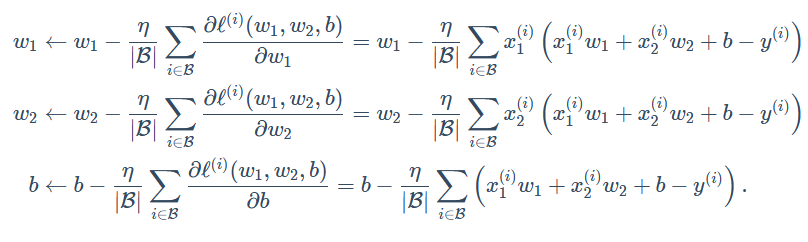

带有$L_2$范数惩罚项的新损失函数为：$$\iota (\omega_1,\omega_2,b)+\frac{\lambda}{2n}||\omega||^2$$

,$\omega=[\omega_1,\omega_2]$。超参数$\omega>0$。当权重参数均为0时，惩罚项最小。当$\omega$较大时，惩罚项在损失函数中的比重较大，这通常会使学到的权重参数的元素较接近0。当$\omega$设为0时，惩罚项完全不起作用。上式中$L_2$范数平方$||\omega||^2$展开后得到$\omega_1^2+\omega_2^2$。有了$L_2$范数惩罚项后，在小批量随机梯度下降中，我们将线性回归一节中权重$\omega_1$和$\omega_2$的迭代方式更改为:

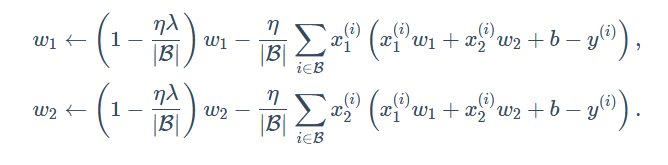

损失函数对参数$\omega$求导改变。

可见，$L_2$范数正则化令权重$\omega_1$和$\omega_2$先自乘小于1的数，再减去不含惩罚项的梯度。因此，$L_2$范数正则化又叫权重衰减。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。实际场景中，我们有时也在惩罚项中添加偏差元素的平方和。

## 3.12.2 高维线性回归实验

以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。设数据样本特征的维度为$p$。对于训练数据集和测试数据集中特征为$x_1,x_2,...,x_p$的任一样本，我们使用如下的线性函数来生成该样本的标签：

$$y=0.05+\sum_{i=1}^{p}0.01x_i+\epsilon$$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。为了较容易地观察过拟合，我们考虑高维线性回归问题，如设维度$p=200$；同时，我们特意把训练数据集的样本数设低，如20。

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

#生成训练集
n_train,n_test=20,100
num_inputs=200 #特征的维度

true_w,true_b=torch.ones(num_inputs,1)*0.01,0.05

features=torch.randn(n_train+n_test,num_inputs)
labels=torch.matmul(features,true_w)+true_b
labels+=torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)#噪声

#分割训练集和测试集
train_features,test_features=features[:n_train,:],features[n_train:,:]
train_labels,test_labels=labels[:n_train],labels[n_train:]

## 3.12.3 从零开始实现

### 3.12.3.1 初始化模型参数

In [9]:
#定义随机初始化模型参数的函数

def init_params():
    w=torch.randn((num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]

### 3.12.3.2 定义$L_2$范数惩罚项

In [11]:
def l2_penalty(w):
    return (w**2).sum()/2

### 3.12.3.3 定义训练和测试

In [17]:
batch_size,num_epochs,lr=1,100,0.003
net=d2l.linreg    
##矢量计算表达式
#def linreg(X,w,b):
#    return torch.mm(X,w)+b #mm函数做矩阵乘法

loss=d2l.squared_loss #平方损失函数

dataset=torch.utils.data.TensorDataset(train_features,train_labels)
train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)#取batch_size的数据

def fit_and_plot(lambd):#超参数lambd
    w,b=init_params()
    train_ls,test_ls=[],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            loss_=loss(net(X,w,b),y)+lambd*l2_penalty(w)
            loss_=loss_.sum()
        
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            loss_.backward()
            d2l.sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

### 3.12.3.4 观察过拟合---训练样本过少

当$lambd$设为0时，我们没有使用权重衰减。结果训练误差远小于测试集上的误差。这是典型的过拟合现象。

L2 norm of w: 14.248211860656738


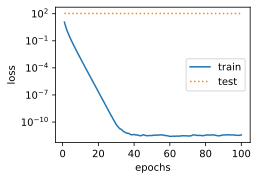

In [18]:
fit_and_plot(lambd=0)

### 3.12.3.5 使用权重衰减

下面我们使用权重衰减。可以看出，训练误差虽然有所提高，但测试集上的误差有所下降。过拟合现象得到一定程度的缓解。另外，权重参数(向量)的$L_2$范数比不使用权重衰减时的更小，此时的权重参数更接近0。

L2 norm of w: 0.042164146900177


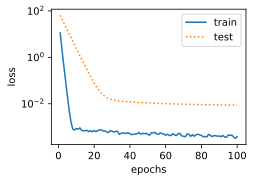

In [20]:
fit_and_plot(lambd=3)

## 3.12.4 简洁实现

直接在构造优化器实例时通过weight_decay参数来指定权重衰减超参数。默认下，PyTorch会对权重和偏差同时衰减。我们可以分别对权重和偏差构造优化器实例，从而只对权重衰减。

In [21]:
def fit_and_plot_pytorch(wd):#衰减参数
    net=nn.Linear(num_inputs,1)
    nn.init.normal_(net.weight,mean=0,std=1)
    nn.init.normal_(net.bias,mean=0,std=1)
    optimizer_w=torch.optim.SGD(params=[net.weight],lr=lr,weight_decay=wd)
    optimizer_b=torch.optim.SGD(params=[net.bias],lr=lr) #不对偏差参数衰减
    
    print(optimizer_w)
    
    train_ls,test_ls=[],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            loss_=loss(net(X),y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            loss_.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()#更新模型参数
            optimizer_b.step()
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:',net.weight.data.norm().item())       
    

L2 norm of w: 12.398832321166992


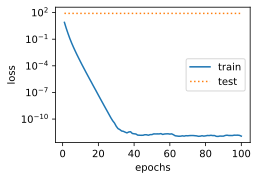

In [24]:
fit_and_plot(0)

L2 norm of w: 0.042615436017513275


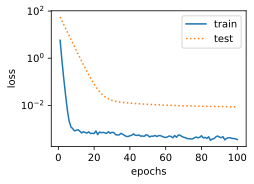

In [25]:
fit_and_plot(3)